In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1003)

datadir = Path('.').resolve().parents[0] / "data"
datadir

PosixPath('/home/mddevine/projects/ml-mushrooms/data')

# data prep

In [4]:
df = pd.read_csv(datadir / "processed" / "mushroom_final.csv")
print(f"{len(df)} observations.")
df.head()

8124 observations.


,class,cap_shape__x,cap_shape__b,cap_shape__s,cap_shape__f,cap_shape__k,cap_shape__c,cap_surface__s,cap_surface__y,cap_surface__f,...,population__v,population__y,population__c,habitat__u,habitat__g,habitat__m,habitat__d,habitat__p,habitat__w,habitat__l
0,p,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,e,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,e,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,p,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,e,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
# features == all columns except the class (our target)
features = df.columns[1:]
X, y = df[features], df['class']
features

Index(['cap_shape__x', 'cap_shape__b', 'cap_shape__s', 'cap_shape__f',
       'cap_shape__k', 'cap_shape__c', 'cap_surface__s', 'cap_surface__y',
       'cap_surface__f', 'cap_surface__g',
       ...
       'population__v', 'population__y', 'population__c', 'habitat__u',
       'habitat__g', 'habitat__m', 'habitat__d', 'habitat__p', 'habitat__w',
       'habitat__l'],
      dtype='object', length=117)

# Train and Evaluate

In [8]:
from collections import namedtuple
Experiment = namedtuple(
    'Experiment',
    ['k', 'train_index', 'test_index', 'clf', 'predictions', 'accuracy'])

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=10, shuffle=True, random_state=9999)
all_experiments = {}
all_accuracies = []
for k, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf = RandomForestClassifier(n_jobs=2, random_state=1003)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    all_accuracies.append(acc)
    all_experiments[k] = Experiment(k, train_index, test_index, clf, predictions, acc)
    print(f"{k=}, {len(train_index)}, {len(test_index)} --> {acc=}")
    
print(f"average accuracy across runs = {round(sum(all_accuracies) / len(all_accuracies), 2)}")

k=0, 7311, 813 --> acc=1.0
k=1, 7311, 813 --> acc=1.0
k=2, 7311, 813 --> acc=1.0
k=3, 7311, 813 --> acc=1.0
k=4, 7312, 812 --> acc=1.0
k=5, 7312, 812 --> acc=1.0
k=6, 7312, 812 --> acc=1.0
k=7, 7312, 812 --> acc=1.0
k=8, 7312, 812 --> acc=1.0
k=9, 7312, 812 --> acc=1.0
average accuracy across runs = 1.0


# review mismatches
of course there are none as we were 100% accurate

In [12]:
for k, exp in all_experiments.items():
    for i, (actual, pred) in enumerate(zip(y.loc[exp.test_index], exp.predictions)):
        if actual != pred:
            print(f"{k=}:{actual=} {pred=}, index={exp.test_index[i]}")

# feature importance

In [14]:
data = []
for k, exp in all_experiments.items():
    data.append(exp.clf.feature_importances_)
    
feat_imp_df = pd.DataFrame(data, columns=features)
feat_imp_df.head()

,cap_shape__x,cap_shape__b,cap_shape__s,cap_shape__f,cap_shape__k,cap_shape__c,cap_surface__s,cap_surface__y,cap_surface__f,cap_surface__g,...,population__v,population__y,population__c,habitat__u,habitat__g,habitat__m,habitat__d,habitat__p,habitat__w,habitat__l
0,0.001086,0.001802,0.000636,0.001047,0.000481,0.000114,0.004301,0.002285,0.005978,0.000261,...,0.021538,0.003950,0.003122,0.011224,0.008111,0.003293,0.012780,0.002696,0.002169,0.001488
1,0.001011,0.001235,0.000567,0.000809,0.000196,0.000050,0.004977,0.001569,0.005871,0.000158,...,0.023826,0.004873,0.003139,0.010093,0.008229,0.004416,0.011773,0.002173,0.001913,0.000950
2,0.000815,0.001114,0.000595,0.001721,0.000670,0.000113,0.006629,0.001967,0.004992,0.000199,...,0.024377,0.003684,0.002297,0.011741,0.007573,0.004739,0.010458,0.002408,0.001953,0.001813
3,0.000908,0.001100,0.000222,0.001333,0.000523,0.000102,0.005258,0.001757,0.006080,0.000326,...,0.023135,0.003694,0.001906,0.012594,0.008449,0.004300,0.011063,0.001978,0.002511,0.001049
4,0.000789,0.001522,0.000358,0.000971,0.000184,0.000062,0.006563,0.002596,0.007050,0.000278,...,0.023210,0.003157,0.002583,0.008582,0.007061,0.004711,0.009015,0.002835,0.000984,0.000990


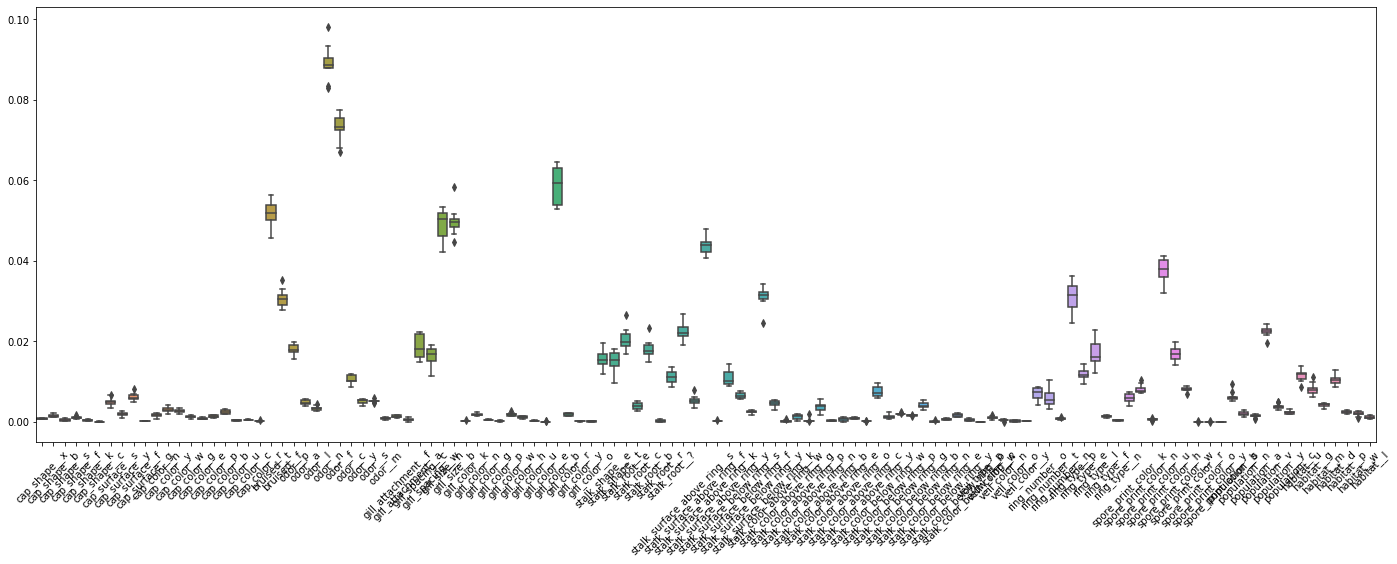

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 8)
chart = sns.boxplot(data=feat_imp_df)    
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart;